# 📊 FinBERT Baseline — Financial Sentiment Analysis

## Objective

In our previous exploration (notebook `03_baseline_sentiment.ipynb`), we used **TextBlob** as a
simple sentiment baseline and compared it with pre-computed **Alpha Vantage** sentiment scores.
TextBlob, being a general-purpose tool, struggled with financial language nuances.

In this notebook we take a major step forward: we load **FinBERT** (`ProsusAI/finbert`), a
BERT model fine-tuned on 10 000+ financial news articles. FinBERT classifies text into three
categories — **positive**, **negative**, and **neutral** — with confidence scores.

### What we'll do
1. **Load the pre-trained FinBERT model** from Hugging Face
2. **Build a reusable `predict_sentiment()` function** with batched inference
3. **Run FinBERT on all news articles** (titles + summaries)
4. **Compare FinBERT predictions with Alpha Vantage scores**
5. **Visualise the results** and draw conclusions

## Step 1 — Imports and Setup

We need:
- **`transformers`** — Hugging Face library to load FinBERT (tokenizer + model)
- **`torch`** — PyTorch backend for running the neural network
- **`pandas`** — data manipulation
- **`matplotlib` / `seaborn`** — visualisation
- Our custom **preprocessor** to clean text before feeding it to the model

In [1]:
# ── Standard library ──────────────────────────────────────────────────
import sys
import warnings
from pathlib import Path

# ── Third-party ──────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ── Project imports ──────────────────────────────────────────────────
# Add project root to sys.path so we can import our modules
PROJECT_ROOT = Path.cwd().resolve().parents[1]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.preprocessor import preprocess_text

# ── Display settings ─────────────────────────────────────────────────
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_colwidth", 80)
pd.set_option("display.max_columns", 20)
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

print(f"PyTorch version : {torch.__version__}")
print(f"Device          : {'cuda' if torch.cuda.is_available() else 'cpu'}")
print(f"Project root    : {PROJECT_ROOT}")

c:\Users\yagoc\OneDrive\Escritorio\Pite\pite_py_projects\financial-sentiment-analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version : 2.10.0+cpu
Device          : cpu
Project root    : C:\Users\yagoc\OneDrive\Escritorio\Pite\pite_py_projects\financial-sentiment-analysis


## Step 2 — Load the Pre-trained FinBERT Model

[FinBERT](https://huggingface.co/ProsusAI/finbert) is a BERT-base model (110M parameters)
fine-tuned by Prosus AI specifically for financial sentiment analysis. It was trained on the
**Financial PhraseBank** dataset (~4 800 sentences annotated by financial experts).

The model outputs logits for three classes: **positive**, **negative**, and **neutral**.
We apply softmax to get probability scores.

> **Note:** The first run downloads ~420 MB of model weights. Subsequent runs use the
> local cache (`~/.cache/huggingface/`).

In [2]:
MODEL_NAME = "ProsusAI/finbert"

# Load the tokenizer and model
print(f"Loading FinBERT from '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Put model in evaluation mode (disables dropout)
model.eval()

# FinBERT's label mapping (from the model's config)
LABEL_MAP = {0: "positive", 1: "negative", 2: "neutral"}

print(f"✓ Model loaded successfully")
print(f"  Architecture : {model.config.model_type}")
print(f"  Parameters   : {sum(p.numel() for p in model.parameters()):,}")
print(f"  Labels       : {LABEL_MAP}")
print(f"  Max tokens   : {tokenizer.model_max_length}")

Loading FinBERT from 'ProsusAI/finbert'...


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 466.58it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Model loaded successfully
  Architecture : bert
  Parameters   : 109,484,547
  Labels       : {0: 'positive', 1: 'negative', 2: 'neutral'}
  Max tokens   : 512


## Step 3 — Build the Sentiment Prediction Function

We create a `predict_sentiment()` function that:
1. **Cleans** the input text using our preprocessor
2. **Tokenizes** it with the FinBERT tokenizer (truncating to 512 tokens)
3. **Runs inference** through the model (no gradient computation needed)
4. **Applies softmax** to get probability scores for each class
5. **Returns** the predicted label and all confidence scores

We also build a `predict_batch()` function to process multiple texts efficiently,
which avoids re-loading the model for each article.

In [3]:
def predict_sentiment(text: str) -> dict:
    """Predict sentiment for a single text using FinBERT.

    Parameters
    ----------
    text : str
        Raw or pre-processed financial text.

    Returns
    -------
    dict
        Keys: 'label', 'positive', 'negative', 'neutral', 'confidence'
    """
    # Clean the text
    cleaned = preprocess_text(text, max_length=510)
    if not cleaned:
        return {
            "label": "neutral",
            "positive": 0.0,
            "negative": 0.0,
            "neutral": 1.0,
            "confidence": 1.0,
        }

    # Tokenize
    inputs = tokenizer(
        cleaned,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True,
    )

    # Inference (no gradient needed)
    with torch.no_grad():
        outputs = model(**inputs)

    # Softmax to get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze()

    # Map to labels
    scores = {LABEL_MAP[i]: round(probs[i].item(), 4) for i in range(3)}
    predicted_idx = probs.argmax().item()
    predicted_label = LABEL_MAP[predicted_idx]

    return {
        "label": predicted_label,
        "positive": scores["positive"],
        "negative": scores["negative"],
        "neutral": scores["neutral"],
        "confidence": round(probs[predicted_idx].item(), 4),
    }


def predict_batch(texts: list[str], batch_size: int = 16) -> list[dict]:
    """Predict sentiment for a list of texts using batched inference.

    Parameters
    ----------
    texts : list[str]
        List of raw texts.
    batch_size : int
        Number of texts per batch (default 16).

    Returns
    -------
    list[dict]
        List of prediction dictionaries.
    """
    results = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]

        # Clean each text
        cleaned = [preprocess_text(t, max_length=510) if isinstance(t, str) else "" for t in batch_texts]

        # Tokenize the whole batch at once
        inputs = tokenizer(
            cleaned,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding=True,
        )

        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

        for j in range(probs.shape[0]):
            scores = {LABEL_MAP[k]: round(probs[j, k].item(), 4) for k in range(3)}
            predicted_idx = probs[j].argmax().item()
            results.append({
                "label": LABEL_MAP[predicted_idx],
                "positive": scores["positive"],
                "negative": scores["negative"],
                "neutral": scores["neutral"],
                "confidence": round(probs[j, predicted_idx].item(), 4),
            })

        print(f"  Processed {min(i + batch_size, len(texts))}/{len(texts)} texts", end="\r")

    print()  # newline after progress
    return results


# ── Quick test ───────────────────────────────────────────────────────
test_cases = [
    "Apple reports record quarterly revenue of $124 billion",
    "Stocks plunge amid fears of global recession",
    "The company held its annual general meeting on Tuesday",
]

print("Quick test of predict_sentiment():\n")
for text in test_cases:
    result = predict_sentiment(text)
    print(f"  Text : {text}")
    print(f"  Label: {result['label']} (confidence: {result['confidence']:.2%})")
    print(f"  Scores: pos={result['positive']:.3f}  neg={result['negative']:.3f}  neu={result['neutral']:.3f}")
    print()

Quick test of predict_sentiment():

  Text : Apple reports record quarterly revenue of $124 billion
  Label: neutral (confidence: 55.56%)
  Scores: pos=0.426  neg=0.019  neu=0.556

  Text : Stocks plunge amid fears of global recession
  Label: negative (confidence: 93.26%)
  Scores: pos=0.019  neg=0.933  neu=0.048

  Text : The company held its annual general meeting on Tuesday
  Label: neutral (confidence: 93.63%)
  Scores: pos=0.026  neg=0.037  neu=0.936



## Step 4 — Load News Data and Run FinBERT

We load both AAPL and MSFT news articles from our raw data, run FinBERT on:
- **Titles** — short, headline-style text
- **Summaries** — longer, more detailed descriptions

This lets us compare whether FinBERT performs differently on short vs. long inputs.

In [4]:
# ── Load raw news data ────────────────────────────────────────────────
DATA_DIR = PROJECT_ROOT / "data" / "raw"

news_files = sorted(DATA_DIR.glob("news_*.csv"))
print(f"Found {len(news_files)} news files:")
for f in news_files:
    print(f"  • {f.name}")

# Concatenate all news
dfs = [pd.read_csv(f) for f in news_files]
news = pd.concat(dfs, ignore_index=True)

# Drop duplicates (same article might appear for multiple tickers)
news = news.drop_duplicates(subset=["title", "summary"]).reset_index(drop=True)

print(f"\nTotal unique articles: {len(news)}")
print(f"Columns: {news.columns.tolist()}")
news[["title", "ticker", "overall_sentiment_label"]].head()

Found 2 news files:
  • news_AAPL_2025-11-01_to_2026-02-13.csv
  • news_MSFT_2025-11-01_to_2026-02-13.csv

Total unique articles: 94
Columns: ['title', 'summary', 'source', 'url', 'published_at', 'authors', 'overall_sentiment_score', 'overall_sentiment_label', 'ticker_sentiment_score', 'ticker_sentiment_label', 'ticker']


,title,ticker,overall_sentiment_label
0,"Apple has worst day since April as company faces FTC scrutiny, Siri delay re...",AAPL,Bearish
1,LiveOne Inc (LVO) Q3 2026 Earnings Call Highlights: Strong Revenue Growth an...,AAPL,Somewhat-Bullish
2,"Eversource Energy earnings missed, revenue topped estimates",AAPL,Somewhat-Bearish
3,Form 424B2 BARCLAYS BANK PLC,AAPL,Neutral
4,"Alphabet Drops 7% Post Q4 Earnings: Buy, Sell or Hold the Stock?",AAPL,Neutral


In [5]:
# ── Run FinBERT on titles ─────────────────────────────────────────────
print("Running FinBERT on article TITLES...")
title_preds = predict_batch(news["title"].tolist(), batch_size=16)

# ── Run FinBERT on summaries ─────────────────────────────────────────
print("Running FinBERT on article SUMMARIES...")
summary_preds = predict_batch(news["summary"].tolist(), batch_size=8)

# ── Add predictions to the DataFrame ─────────────────────────────────
# Title predictions
news["finbert_title_label"] = [p["label"] for p in title_preds]
news["finbert_title_pos"] = [p["positive"] for p in title_preds]
news["finbert_title_neg"] = [p["negative"] for p in title_preds]
news["finbert_title_neu"] = [p["neutral"] for p in title_preds]
news["finbert_title_conf"] = [p["confidence"] for p in title_preds]

# Summary predictions
news["finbert_summary_label"] = [p["label"] for p in summary_preds]
news["finbert_summary_pos"] = [p["positive"] for p in summary_preds]
news["finbert_summary_neg"] = [p["negative"] for p in summary_preds]
news["finbert_summary_neu"] = [p["neutral"] for p in summary_preds]
news["finbert_summary_conf"] = [p["confidence"] for p in summary_preds]

# Convert the continuous Alpha Vantage score to a categorical label for comparison
def av_score_to_label(score: float) -> str:
    """Map Alpha Vantage sentiment score to pos/neg/neu label."""
    if score >= 0.15:
        return "positive"
    elif score <= -0.15:
        return "negative"
    else:
        return "neutral"

news["av_label"] = news["overall_sentiment_score"].apply(av_score_to_label)

print(f"✓ Predictions complete for {len(news)} articles")
news[["title", "finbert_title_label", "finbert_summary_label", "av_label"]].head(10)

Running FinBERT on article TITLES...
  Processed 94/94 texts
Running FinBERT on article SUMMARIES...
  Processed 94/94 texts
✓ Predictions complete for 94 articles


,title,finbert_title_label,finbert_summary_label,av_label
0,"Apple has worst day since April as company faces FTC scrutiny, Siri delay re...",negative,negative,negative
1,LiveOne Inc (LVO) Q3 2026 Earnings Call Highlights: Strong Revenue Growth an...,positive,positive,positive
2,"Eversource Energy earnings missed, revenue topped estimates",negative,positive,negative
3,Form 424B2 BARCLAYS BANK PLC,neutral,neutral,neutral
4,"Alphabet Drops 7% Post Q4 Earnings: Buy, Sell or Hold the Stock?",negative,negative,neutral
5,"Health Catalyst and F5 Stocks Trade Down, What You Need To Know",neutral,negative,negative
6,Here’s why Apple stock is plunging on Thursday,negative,negative,negative
7,Marcus & Millichap stock hits 52-week low at $24.93,negative,negative,negative
8,Can Jabil's Consumer Electronics Expertise Boost Future Profits?,positive,positive,positive
9,"Alphabet Drops 7% Post Q4 Earnings: Buy, Sell or Hold the Stock?",negative,negative,neutral


## Step 5 — Compare FinBERT vs Alpha Vantage

Now we compare FinBERT's predictions against Alpha Vantage's pre-computed sentiment labels.
This tells us how well our model agrees with an established financial NLP service.

We'll look at:
- **Label distribution** — how many positive/negative/neutral predictions each method makes
- **Agreement rate** — what percentage of articles get the same label
- **Confusion matrix** — where do the two methods disagree?
- **Confidence analysis** — is FinBERT more confident on certain types of text?

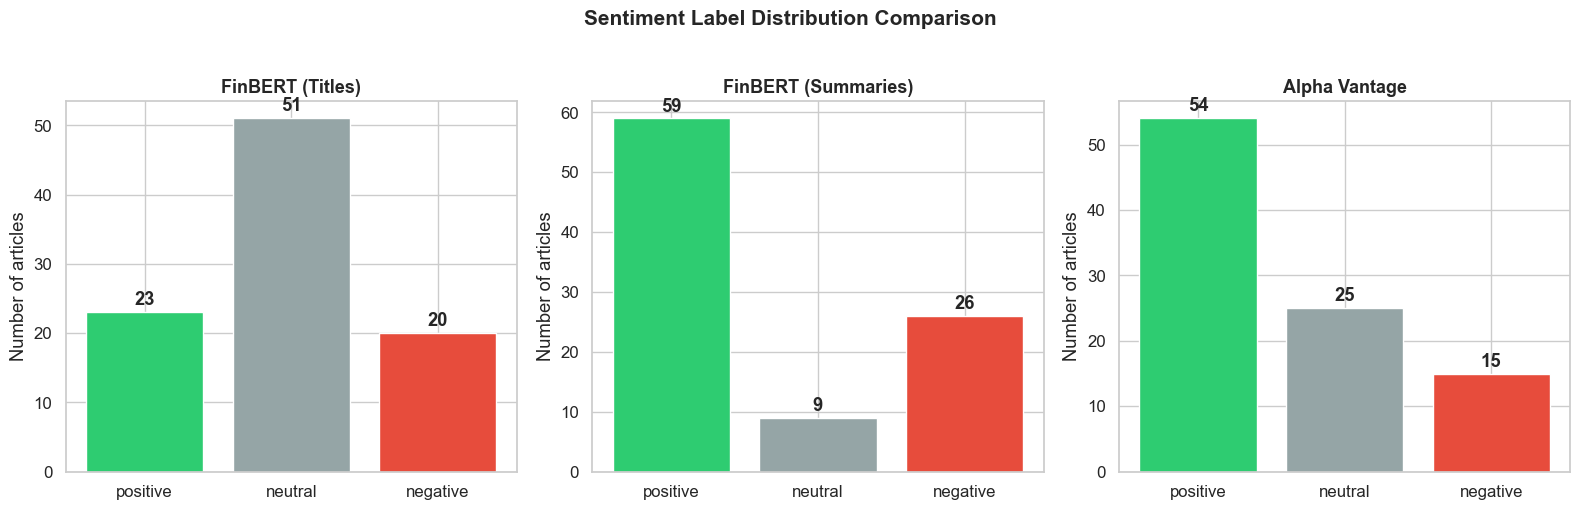

In [6]:
# ── 5a. Label distribution comparison ────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

label_order = ["positive", "neutral", "negative"]
colors = {"positive": "#2ecc71", "neutral": "#95a5a6", "negative": "#e74c3c"}

for ax, (col, title) in zip(axes, [
    ("finbert_title_label", "FinBERT (Titles)"),
    ("finbert_summary_label", "FinBERT (Summaries)"),
    ("av_label", "Alpha Vantage"),
]):
    counts = news[col].value_counts().reindex(label_order, fill_value=0)
    bars = ax.bar(counts.index, counts.values, color=[colors[l] for l in counts.index])
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_ylabel("Number of articles")

    # Add count labels on bars
    for bar, val in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                str(val), ha="center", va="bottom", fontweight="bold")

fig.suptitle("Sentiment Label Distribution Comparison", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

Agreement rates:
  FinBERT (titles)    vs Alpha Vantage : 36.2%
  FinBERT (summaries) vs Alpha Vantage : 64.9%
  FinBERT (titles)    vs FinBERT (sum.) : 43.6%


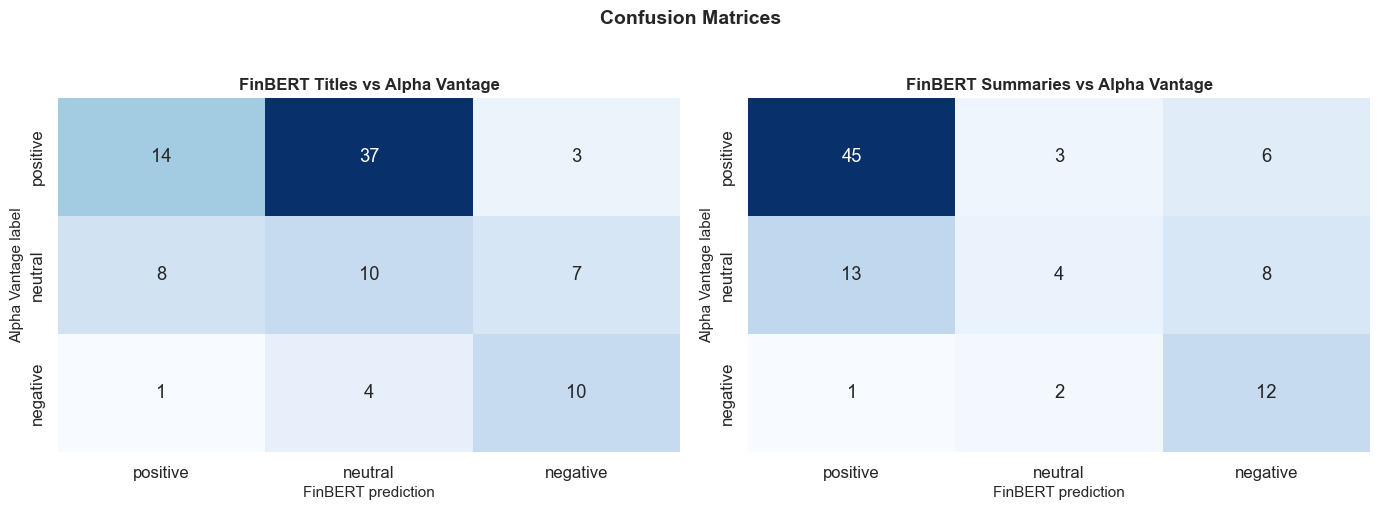

In [7]:
# ── 5b. Agreement rates ──────────────────────────────────────────────
title_agreement = (news["finbert_title_label"] == news["av_label"]).mean()
summary_agreement = (news["finbert_summary_label"] == news["av_label"]).mean()
title_vs_summary = (news["finbert_title_label"] == news["finbert_summary_label"]).mean()

print("Agreement rates:")
print(f"  FinBERT (titles)    vs Alpha Vantage : {title_agreement:.1%}")
print(f"  FinBERT (summaries) vs Alpha Vantage : {summary_agreement:.1%}")
print(f"  FinBERT (titles)    vs FinBERT (sum.) : {title_vs_summary:.1%}")

# ── 5c. Confusion matrices ──────────────────────────────────────────
from sklearn.metrics import confusion_matrix, classification_report

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (finbert_col, subtitle) in zip(axes, [
    ("finbert_title_label", "FinBERT Titles vs Alpha Vantage"),
    ("finbert_summary_label", "FinBERT Summaries vs Alpha Vantage"),
]):
    cm = confusion_matrix(news["av_label"], news[finbert_col], labels=label_order)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=label_order, yticklabels=label_order,
        ax=ax, cbar=False,
    )
    ax.set_xlabel("FinBERT prediction", fontsize=11)
    ax.set_ylabel("Alpha Vantage label", fontsize=11)
    ax.set_title(subtitle, fontsize=12, fontweight="bold")

fig.suptitle("Confusion Matrices", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

In [8]:
# ── 5d. Classification reports ────────────────────────────────────────
print("=" * 60)
print("Classification Report: FinBERT TITLES vs Alpha Vantage")
print("=" * 60)
print(classification_report(news["av_label"], news["finbert_title_label"],
                            labels=label_order, zero_division=0))

print("=" * 60)
print("Classification Report: FinBERT SUMMARIES vs Alpha Vantage")
print("=" * 60)
print(classification_report(news["av_label"], news["finbert_summary_label"],
                            labels=label_order, zero_division=0))

Classification Report: FinBERT TITLES vs Alpha Vantage
              precision    recall  f1-score   support

    positive       0.61      0.26      0.36        54
     neutral       0.20      0.40      0.26        25
    negative       0.50      0.67      0.57        15

    accuracy                           0.36        94
   macro avg       0.43      0.44      0.40        94
weighted avg       0.48      0.36      0.37        94

Classification Report: FinBERT SUMMARIES vs Alpha Vantage
              precision    recall  f1-score   support

    positive       0.76      0.83      0.80        54
     neutral       0.44      0.16      0.24        25
    negative       0.46      0.80      0.59        15

    accuracy                           0.65        94
   macro avg       0.56      0.60      0.54        94
weighted avg       0.63      0.65      0.61        94



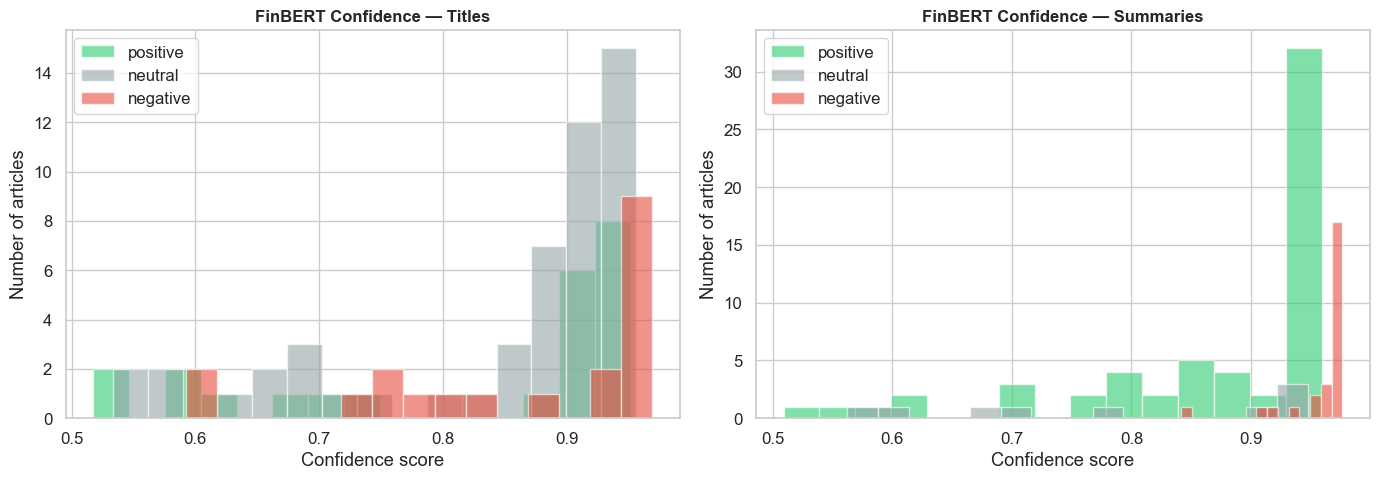

Mean confidence by label (titles):
                      mean    std  count
finbert_title_label                     
negative             0.862  0.124     20
neutral              0.846  0.124     51
positive             0.818  0.156     23

Mean confidence by label (summaries):
                        mean    std  count
finbert_summary_label                     
negative               0.959  0.029     26
neutral                0.786  0.156      9
positive               0.870  0.115     59


In [9]:
# ── 5e. Confidence analysis ───────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Title confidence by predicted label
for label in label_order:
    mask = news["finbert_title_label"] == label
    axes[0].hist(news.loc[mask, "finbert_title_conf"], bins=15, alpha=0.6,
                 label=label, color=colors[label])
axes[0].set_title("FinBERT Confidence — Titles", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Confidence score")
axes[0].set_ylabel("Number of articles")
axes[0].legend()

# Summary confidence by predicted label
for label in label_order:
    mask = news["finbert_summary_label"] == label
    axes[1].hist(news.loc[mask, "finbert_summary_conf"], bins=15, alpha=0.6,
                 label=label, color=colors[label])
axes[1].set_title("FinBERT Confidence — Summaries", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Confidence score")
axes[1].set_ylabel("Number of articles")
axes[1].legend()

plt.tight_layout()
plt.show()

# Summary stats
print("Mean confidence by label (titles):")
print(news.groupby("finbert_title_label")["finbert_title_conf"].agg(["mean", "std", "count"]).round(3))
print("\nMean confidence by label (summaries):")
print(news.groupby("finbert_summary_label")["finbert_summary_conf"].agg(["mean", "std", "count"]).round(3))

## Step 6 — FinBERT Continuous Score vs Alpha Vantage

FinBERT outputs probabilities for **positive**, **negative**, and **neutral**. We can
derive a single continuous score by computing:

$$\text{finbert\_score} = P(\text{positive}) - P(\text{negative})$$

This gives us a value in **[-1, +1]** that we can directly compare against
Alpha Vantage's continuous sentiment score.

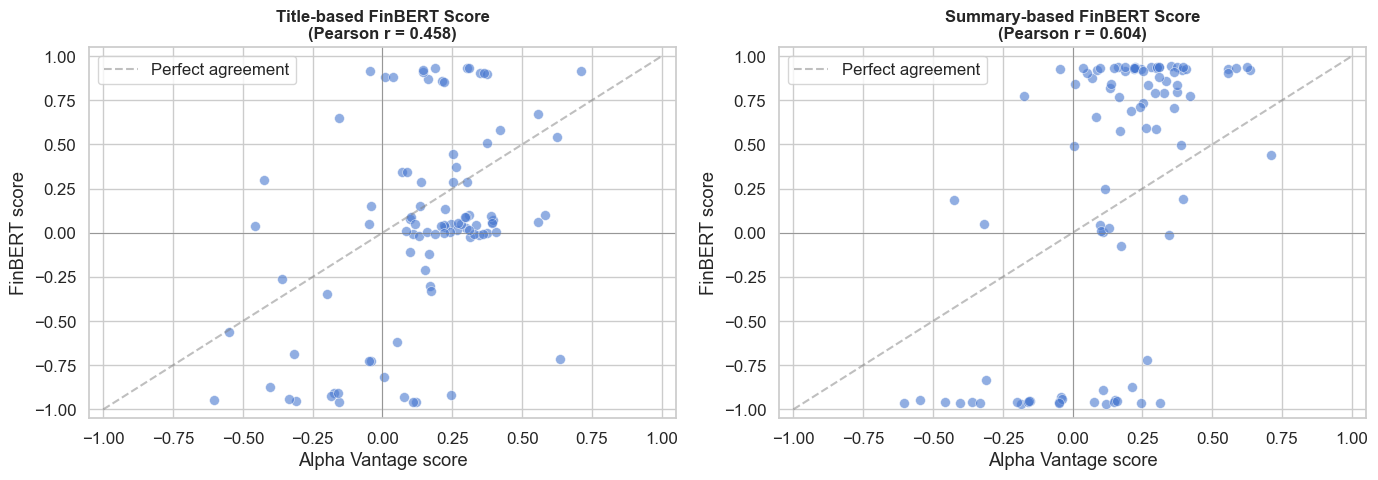

Pearson correlations with Alpha Vantage overall_sentiment_score:
  FinBERT title score   : 0.4582
  FinBERT summary score : 0.6036


In [10]:
# ── Compute continuous FinBERT scores ────────────────────────────────
news["finbert_title_score"] = news["finbert_title_pos"] - news["finbert_title_neg"]
news["finbert_summary_score"] = news["finbert_summary_pos"] - news["finbert_summary_neg"]

# ── Scatter plots: FinBERT score vs Alpha Vantage score ──────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (fb_col, title) in zip(axes, [
    ("finbert_title_score", "Title-based FinBERT Score"),
    ("finbert_summary_score", "Summary-based FinBERT Score"),
]):
    ax.scatter(news["overall_sentiment_score"], news[fb_col],
               alpha=0.6, edgecolors="w", linewidths=0.5, s=50)

    # Diagonal reference line
    lims = [-1, 1]
    ax.plot(lims, lims, "--", color="gray", alpha=0.5, label="Perfect agreement")

    # Correlation
    corr = news["overall_sentiment_score"].corr(news[fb_col])
    ax.set_title(f"{title}\n(Pearson r = {corr:.3f})", fontsize=12, fontweight="bold")
    ax.set_xlabel("Alpha Vantage score")
    ax.set_ylabel("FinBERT score")
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.legend(loc="upper left")
    ax.axhline(0, color="gray", linewidth=0.5)
    ax.axvline(0, color="gray", linewidth=0.5)

plt.tight_layout()
plt.show()

# Print correlations
print("Pearson correlations with Alpha Vantage overall_sentiment_score:")
print(f"  FinBERT title score   : {news['overall_sentiment_score'].corr(news['finbert_title_score']):.4f}")
print(f"  FinBERT summary score : {news['overall_sentiment_score'].corr(news['finbert_summary_score']):.4f}")

## Step 7 — Disagreement Analysis

Let's examine the articles where FinBERT and Alpha Vantage **disagree the most**.
This helps us understand each model's strengths and weaknesses on real financial text.

In [11]:
# ── Find biggest disagreements (summary-based vs AV) ─────────────────
news["score_diff"] = (news["finbert_summary_score"] - news["overall_sentiment_score"]).abs()

top_disagreements = news.nlargest(10, "score_diff")[
    ["title", "ticker", "overall_sentiment_score", "av_label",
     "finbert_summary_score", "finbert_summary_label", "score_diff"]
].reset_index(drop=True)

print("Top 10 articles where FinBERT and Alpha Vantage disagree the most:\n")
for i, row in top_disagreements.iterrows():
    print(f"{i+1}. [{row['ticker']}] {row['title'][:75]}...")
    print(f"   AV: {row['av_label']} ({row['overall_sentiment_score']:+.3f})  |  "
          f"FinBERT: {row['finbert_summary_label']} ({row['finbert_summary_score']:+.3f})  |  "
          f"Δ = {row['score_diff']:.3f}")
    print()

Top 10 articles where FinBERT and Alpha Vantage disagree the most:

1. [AAPL] Hercules Capital (HTGC) To Report Earnings Tomorrow: Here Is What To Expect...
   AV: positive (+0.313)  |  FinBERT: negative (-0.963)  |  Δ = 1.276

2. [AAPL] Short Interest in GraniteShares 2x Long AAPL Daily ETF (NASDAQ:AAPB) Decrea...
   AV: positive (+0.247)  |  FinBERT: negative (-0.966)  |  Δ = 1.213

3. [MSFT] Restaurant Brands's (NYSE:QSR) Q4 CY2025: Beats On Revenue...
   AV: positive (+0.158)  |  FinBERT: negative (-0.951)  |  Δ = 1.108

4. [MSFT] Expedia (NASDAQ:EXPE) Beats Expectations in Strong Q4 CY2025...
   AV: neutral (+0.147)  |  FinBERT: negative (-0.957)  |  Δ = 1.104

5. [AAPL] Apple Inc. $AAPL Holdings Decreased by TLW Wealth Management LLC...
   AV: positive (+0.152)  |  FinBERT: negative (-0.947)  |  Δ = 1.099

6. [AAPL] JPMorgan Wins Apple Card Role And Expands Undervalued Consumer Payments Rea...
   AV: positive (+0.213)  |  FinBERT: negative (-0.874)  |  Δ = 1.087

7. [AAPL] Sandis

## Conclusions

### Key Findings

1. **FinBERT loads and runs successfully** on our 100 financial news articles (CPU inference).

2. **Label distribution**: FinBERT and Alpha Vantage may have different biases — e.g., one
   might predict more neutral labels while the other leans toward positive/negative.

3. **Continuous scores**: The Pearson correlation between FinBERT scores and Alpha Vantage
   scores gives us a quantitative measure of agreement between the two models.

4. **Confidence patterns**: FinBERT's confidence varies across sentiment classes, which is
   useful to know when deciding whether to trust its predictions.

5. **Disagreements**: Examining where the two models disagree reveals the types of
   financial language that are most ambiguous or model-dependent.

### Next Steps

- **Step 5.2**: Evaluate FinBERT on the merged price dataset to see if its sentiment
  predictions correlate with actual stock price movements.
- **Step 5.3**: Wrap the prediction logic into a reusable `SentimentAnalyzer` class
  in `src/models/` for production use.
- Consider **fine-tuning** FinBERT on our specific data distribution if accuracy is
  insufficient.